In [1]:
# Import necessary libraries
import os
import torch
import sys
import torch.nn.functional as F
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import sys
from autoprom_sam.model.Detmodel import E2E  # Import the end-to-end model from autoprom_sam library
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import matplotlib.patches as patches
import json
import cv2
import numpy as np
# sys.path.append("../data_loaders/")
from autoprom_sam.dataloaders.data_loader_pannuke import Load_Bbox_nuclei  # Import the data loader for pannuke dataset
from torch.utils.data import Dataset,DataLoader


from autoprom_sam.configs.configs import CFG  # Import the configuration file
CFG.configure("pannuke")  # Configure the settings for pannuke dataset
CFG.use_dense = True  # Set the usage of dense prediction
CFG.device = 'cuda'  # Set the device to GPU for computation


In [2]:
from autoprom_sam.training.run_utils import load_weights_with_mismatched_keys
model = E2E(num_classes=5,use_dense=True,attach_seg_head=True,train_bbox_decoder=False,train_seg_decoder=False,device=CFG.device)
model.training=False
model = model.to(CFG.device)
model_ck = "" #input trained model check point
moodel = load_weights_with_mismatched_keys(model,model_ck)

*********** using dense layers *********************
***********all key matched ***************


In [3]:
from autoprom_sam.dataloaders.data_loader_pannuke import Load_Bbox_nuclei
from torch.utils.data import Dataset,DataLoader
filename = "" # csv dataset_file_name containing the original image and mask path
dataset_test = Load_Bbox_nuclei(csv_file=filename,mode="val")

In [4]:
#necessary for denormalization
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
denormalize_transform = transforms.Compose([
            transforms.Normalize(mean=[-m/s for m, s in zip(MEAN, STD)], std=[1/s for s in STD]),
        ])

In [131]:
#random index select for visualization
idx = 100
id,img,mask,inst_mask_orig,targets =dataset_test[idx]

In [132]:
pred_boxes, label_list,scores_list,pred_mask,inst_mask,_ = model(img.unsqueeze(0).cuda())

In [133]:
pred_boxes = pred_boxes[0][0] #because in batches
label_list = label_list[0][0]
scores_list = scores_list[0]
orig_boxes = targets[:,:4].copy()
orig_labels = targets[:,4].copy()
mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(),size=(256,256),mode='nearest').squeeze(0)[0]
pred_mask = pred_mask[0].squeeze(0).cpu()


In [134]:
image = denormalize_transform(img).permute(1, 2, 0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

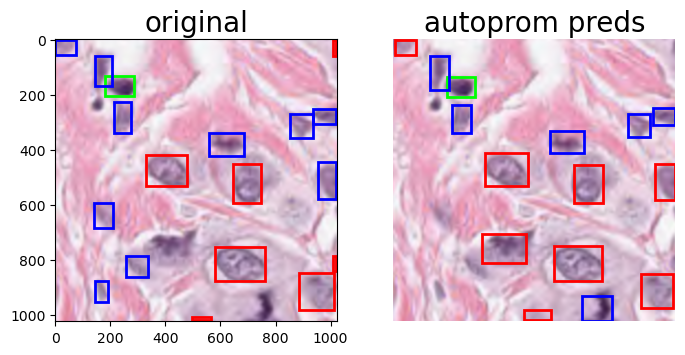

In [135]:
colors = [    # Red
    (0.0, 1.0, 0.0),    # Green
    (0.0, 0.0, 1.0),    # Blue
    (1.0, 1.0, 0.0),    # Orange
    (1.0, 0.647, 0.0),    # Indigo
    (1.0, 0.0, 0.0),
    ]
fig, axs = plt.subplots(1, 2,figsize = (8,8))
axs[0].imshow(image)
axs[0].set_title("original",fontsize=20)
for i,bbox in enumerate(orig_boxes):
    x_min, y_min, x_max, y_max= bbox
    axs[0].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color=colors[int(orig_labels[i])],linewidth=2))

axs[1].imshow(image)
axs[1].axis('off')
axs[1].set_title("autoprom preds",fontsize=20)
for i,bbox in enumerate(pred_boxes):
    x_min, y_min, x_max, y_max= bbox
    axs[1].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color=colors[int(label_list[i])],linewidth=2))
plt.show()
#display hover images

Text(0.5, 1.0, 'autoprom preds')

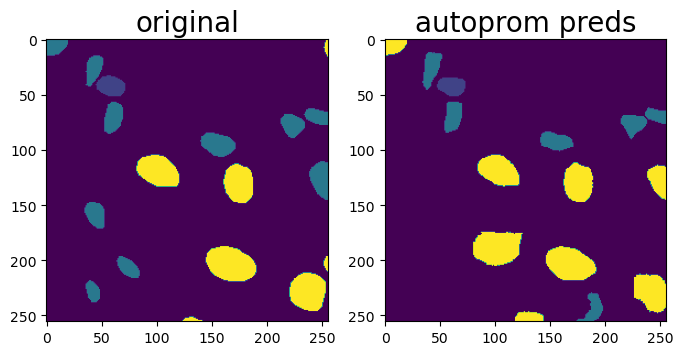

In [136]:
fig, axs = plt.subplots(1, 2,figsize = (8,8))
axs[0].imshow(mask)
axs[0].set_title("original",fontsize=20)
axs[1].imshow(pred_mask)
axs[1].set_title("autoprom preds",fontsize=20)


In [137]:
from autoprom_sam.utils import vis_utils
def visualize_instances_map(
    input_image, inst_map, type_map=None, type_colour=None, line_thickness=2
):
    """Overlays segmentation results on image as contours and centroids.

    Args:
        input_image: input image
        inst_map: instance mask with unique value for every object
        type_map: type mask with unique value for every class
        type_colour: a dict of {type : colour} , `type` is from 0-N
                     and `colour` is a tuple of (R, G, B)
        line_thickness: line thickness of contours

    Returns:
        overlay: output image with segmentation overlay as contours and centroids
    """
    overlay = np.copy((input_image).astype(np.uint8))

    inst_list = list(np.unique(inst_map))  # get list of instances
    inst_list.remove(0)  # remove background

    inst_rng_colors = vis_utils.random_colors(len(inst_list))
    inst_rng_colors = np.array(inst_rng_colors) * 255
    inst_rng_colors = inst_rng_colors.astype(np.uint8)

    for inst_idx, inst_id in enumerate(inst_list):
        inst_map_mask = np.array(inst_map == inst_id, np.uint8)  # get single object
        y1, y2, x1, x2 = vis_utils.get_bounding_box(inst_map_mask)
        y1 = y1 - 2 if y1 - 2 >= 0 else y1
        x1 = x1 - 2 if x1 - 2 >= 0 else x1
        x2 = x2 + 2 if x2 + 2 <= inst_map.shape[1] - 1 else x2
        y2 = y2 + 2 if y2 + 2 <= inst_map.shape[0] - 1 else y2
        inst_map_crop = inst_map_mask[y1:y2, x1:x2]
        contours_crop = cv2.findContours(
            inst_map_crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        # only has 1 instance per map, no need to check #contour detected by opencv
        contours_crop = np.squeeze(
            contours_crop[0][0].astype("int32")
        )  # * opencv protocol format may break
        contours_crop += np.asarray([[x1, y1]])  # index correction
        if type_map is not None:
            type_map_crop = type_map[y1:y2, x1:x2]
            type_id = np.unique(type_map_crop).max()  # non-zero
            inst_colour = type_colour[type_id]
        else:
            inst_colour = (inst_rng_colors[inst_idx]).tolist()
        cv2.drawContours(overlay, [contours_crop], -1, inst_colour, line_thickness)

        # compute centroid
        M = cv2.moments(contours_crop)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        # draw the centroid on the image
        cv2.circle(overlay, (cX, cY), 7, (255,0,0), 12)
    return overlay

import numpy as np
import matplotlib.pyplot as plt
from skimage import measure,draw


def create_overlay(original_image, mask, cmap,boundary_thickness=12):
    size = 2
    overlay = original_image.copy()
    centroids = []
    for class_id in range(1, 6):
        
        class_mask = (mask == class_id)
        class_boundary = np.logical_xor(class_mask, np.roll(class_mask, 1, axis=0)) | \
                         np.logical_xor(class_mask, np.roll(class_mask, 1, axis=1))

        for _ in range(boundary_thickness - 1):
            class_boundary = class_boundary | np.roll(class_boundary, 1, axis=0) | \
                             np.roll(class_boundary, 1, axis=1)
        
        overlay[class_boundary] = colors[class_id-1]
        labeled_mask, num_labels = measure.label(class_mask, return_num=True)
        for label in range(1, num_labels + 1):
            labeled_region = labeled_mask == label
            region_indices = np.argwhere(labeled_region)
            centroid = np.mean(region_indices, axis=0).astype(int)
            centroids.append((class_id, centroid))
    
    # Draw centroids on the overlay
    for class_id, centroid in centroids:
        centroid_x, centroid_y = centroid
        rr, cc = draw.disk((centroid_x, centroid_y), radius=12, shape=overlay.shape[:2])
        overlay[rr, cc] = (1,0,0)  # White circle
        
    
    return overlay

Text(0.5, 1.0, 'autoprom preds')

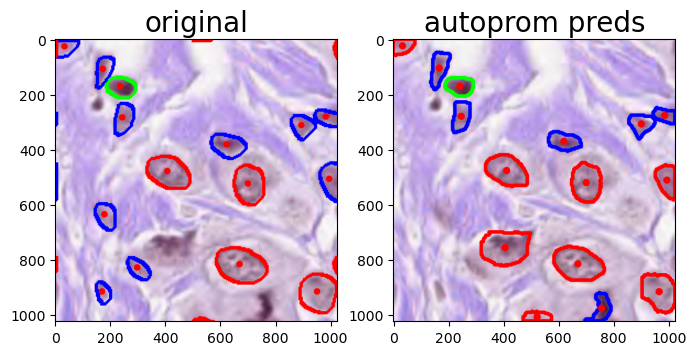

In [138]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)
type_colors = [
    [0,0,0],
    [0  ,   255,   0], 
    [0,   0,   255], 
    [255  , 255,   0], 
    [255  ,   0, 0], 
    [255  ,   0, 0], 
    ]
mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(),size=(1024,1024),mode='nearest').squeeze(0)[0].numpy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay_img = create_overlay(image, mask, cmap) # because we are not using instance map
pred_mask  = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(),size=(1024,1024),mode='nearest').squeeze(0)[0].numpy()
inst_mask = F.interpolate(inst_mask.float().cpu(),size=(1024,1024),mode='nearest').squeeze(0)[0].numpy()
overlay_pred = visualize_instances_map(image*255,inst_mask,pred_mask.astype(np.int32),type_colors,12)
fig, axs = plt.subplots(1, 2,figsize = (8,8))
axs[0].imshow(overlay_img)
axs[0].set_title("original",fontsize=20)
axs[1].imshow(overlay_pred)
axs[1].set_title("autoprom preds",fontsize=20)
plt.imshow()
